<a href="https://colab.research.google.com/github/aribamazharam/efficient-net/blob/main/EfficientNetb0_Timm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.5 MB/s eta 0:00:00


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set random seed for reproducibility
torch.manual_seed(42)

In [4]:
# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224 , 224)),  # EfficientNet-B6 input size is (528, 528)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

In [17]:
# Set path to your train, val, and test directories
data_dir = '/content/drive/MyDrive/data_augmented_split'
# Create train, val, and test datasets
train_dataset = ImageFolder(os.path.join(data_dir, '/content/drive/MyDrive/data_augmented_split/train'), transform=data_transforms)
val_dataset = ImageFolder(os.path.join(data_dir, '/content/drive/MyDrive/data_augmented_split/valid'), transform=data_transforms)
test_dataset = ImageFolder(os.path.join(data_dir, '/content/drive/MyDrive/data_augmented_split/test'), transform=data_transforms)
# Create train, val, and test data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [18]:
# Create model
num_classes = len(train_dataset.classes)
model = timm.create_model('efficientnet_b0', pretrained=True)


In [19]:
#Training loop
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the same device as the input data
model.to(device)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_correct += torch.sum(preds == labels.data)
    train_loss /= len(train_dataset)
    train_accuracy = train_correct.double() / len(train_dataset)
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_correct += torch.sum(preds == labels.data)
    val_loss /= len(val_dataset)
    val_accuracy = val_correct.double() / len(val_dataset)
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy.cpu().numpy())
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy.cpu().numpy())
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


  0%|          | 0/146 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b2087fa8ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b2087fa8ca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/20], Train Loss: 1.6976, Train Accuracy: 0.6098, Val Loss: 0.5911, Val Accuracy: 0.8319


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/20], Train Loss: 0.3197, Train Accuracy: 0.9114, Val Loss: 0.4267, Val Accuracy: 0.8735


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/20], Train Loss: 0.1602, Train Accuracy: 0.9580, Val Loss: 0.2810, Val Accuracy: 0.9168


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/20], Train Loss: 0.1169, Train Accuracy: 0.9687, Val Loss: 0.2973, Val Accuracy: 0.9124


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/20], Train Loss: 0.0998, Train Accuracy: 0.9697, Val Loss: 0.3310, Val Accuracy: 0.9168


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6/20], Train Loss: 0.1235, Train Accuracy: 0.9628, Val Loss: 0.3766, Val Accuracy: 0.8965


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/20], Train Loss: 0.1923, Train Accuracy: 0.9388, Val Loss: 0.5994, Val Accuracy: 0.8319


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8/20], Train Loss: 0.2057, Train Accuracy: 0.9372, Val Loss: 0.3737, Val Accuracy: 0.9000


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9/20], Train Loss: 0.1207, Train Accuracy: 0.9618, Val Loss: 0.3222, Val Accuracy: 0.9142


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/20], Train Loss: 0.0782, Train Accuracy: 0.9746, Val Loss: 0.2130, Val Accuracy: 0.9381


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [11/20], Train Loss: 0.0511, Train Accuracy: 0.9808, Val Loss: 0.2312, Val Accuracy: 0.9354


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [12/20], Train Loss: 0.0523, Train Accuracy: 0.9804, Val Loss: 0.1999, Val Accuracy: 0.9416


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [13/20], Train Loss: 0.0433, Train Accuracy: 0.9802, Val Loss: 0.1989, Val Accuracy: 0.9398


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [14/20], Train Loss: 0.0366, Train Accuracy: 0.9819, Val Loss: 0.1992, Val Accuracy: 0.9416


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [15/20], Train Loss: 0.0359, Train Accuracy: 0.9824, Val Loss: 0.2078, Val Accuracy: 0.9407


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [16/20], Train Loss: 0.0345, Train Accuracy: 0.9836, Val Loss: 0.2217, Val Accuracy: 0.9407


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [17/20], Train Loss: 0.0330, Train Accuracy: 0.9824, Val Loss: 0.2125, Val Accuracy: 0.9407


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [18/20], Train Loss: 0.0350, Train Accuracy: 0.9844, Val Loss: 0.2262, Val Accuracy: 0.9407


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [19/20], Train Loss: 0.0435, Train Accuracy: 0.9822, Val Loss: 0.2752, Val Accuracy: 0.9177


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [20/20], Train Loss: 0.4191, Train Accuracy: 0.8783, Val Loss: 0.7819, Val Accuracy: 0.7991


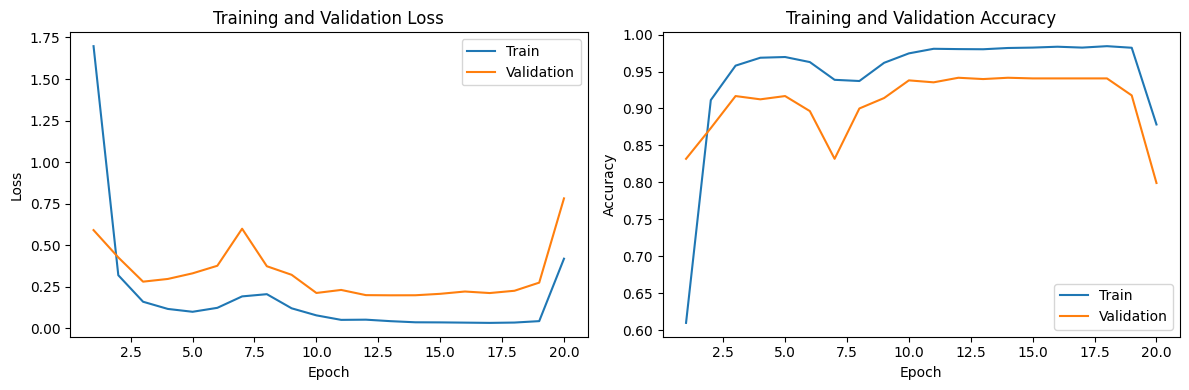

In [21]:
# Plotting the training and validation curves
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train')
plt.plot(epochs, val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
torch.save(model, '/content/drive/MyDrive/efficientnet_b0.pt')